# Evaluating performance of biometric systems
This assignment focusses on evaluating the performance of any biometric system in a verification and identification setting. This assignment will give you insight into the way biometrics systems are evaluated from a performance point of view. Make sure you can properly distinguish the two cases and apply the proper validation procedures. 

* **Verification (a.k.a. authentication)**: authenticating a claimed identity (is this person who he/she claims to be?).

* **Identification**: associate a particular individual with an identity (who is this unidentified individual?)

**The solutions in this assignment are just skeleton examples. Please adapt them where needed.**

Write your code such that you can easily reuse it for the following assignments where you will implement small biometric systems and test them. Many operations have already been implemented in [SciPy](https://docs.scipy.org/doc/numpy/index.html), feel free to use them or any other unless specified otherwise in the assignment.  

In [1]:
# import the required python packages
import numpy as np
import matplotlib.pyplot as plt
# the following meta-command is required to get plots displayed in notebooks
%matplotlib inline

# package for reading xml files
import xml.etree.ElementTree as ET
import os
import pickle
import pandas as pd
# package for data analysis with fast and flexible data structures
import pandas as pd

from tqdm.notebook import tqdm as tqdm_notebook

# import local modules for reading and converting BSSR1 fingerprint score data
import BSSR1

import seaborn as sns

## Realistic validation database

For this experiment we will make use of actual fingerprint similarity scores, from the left and right index fingers. This bypasses all steps of preprocessing, feature extraction and matching and allows us to concentrate on the score evaluation procedures. The scores are the result of comparing an enrolled user's image with the score of the same (genuine scores) or another user (imposter scores). 

The data (biometrics scores set BSSR1) are made available through the American National Institute of Standards and Technologies [(NIST)](https://www.nist.gov/itl/iad/image-group/nist-biometric-scores-set-bssr1). They are provided as part of your assignment folder in the fing-x-fing subfolder. 


### Read the BSSR1 scores and convert them to a manageable format

We provide you here with the code to read the scores from the files. Normally you don't need to change this code. 

The scores are first converted to a similarity matrix with the genuine scores on the diagonal and the imposter scores on the off-diagonal elements. For more information on how these data are structured on file, see: [readme](./fing_x_fing/README.html).

Next,if necessary to reduce calculation times, they can be subsampled. 

Finally, the original (subsampled) scores are converted to a linear list of scores with associated labels of genuine or imposter, which simplifies their use in [scikit-learn](https://scikit-learn.org/stable/index.html) for evaluation.

In [2]:
#Load similarity matrices
li_sim_file=os.path.join("Li_folder","li_sim_mat.csv")
ri_sim_file=os.path.join("Ri_folder","ri_sim_mat.csv")
li_similarity_matrix=pd.read_csv(li_sim_file).set_index("subject_id")
ri_similarity_matrix=pd.read_csv(ri_sim_file).set_index("subject_id")


In [3]:
# convert to genuine and imposter scores, the *_genuine_id provides a mask for the genuine scores
li_genuine_id, li_scores = BSSR1.sim2scores(li_similarity_matrix)

In [4]:
# convert to genuine and imposter scores, the *_genuine_id provides a mask for the genuine scores
ri_genuine_id, ri_scores = BSSR1.sim2scores(ri_similarity_matrix)

## Validation of verification system
In an authentication scenario, one has a binary classification problem: is it the claimed identity or not? We thus have two classes: genuine and imposter

### Evaluation using FMR, FRR, ROC and Precision/Recall curves

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

The performance of these systems can be expressed in a number of ways (see [Jain et al.][1] section 1.4.1.1). 

#### 1. Genuine and imposter score distributions

From the previously calculated genuine and impostor scores for the available data, first generate and plot the genuine and impostor score distributions: 

<p align="center">
    <img src="img/ScoreDistributions.png" width="250" height="auto"/>
</p>



#### <font color=blue> Task 1.1 Plot and describe the score distributions

* Plot the genuine and imposter score distributions in a single plot.
* Do you need to normalize the distributions? Why (not)?
* Describe qualitatively this combined plot (hint: limit the score range for better understanding)
</font>

In [5]:
from sklearn.preprocessing import MinMaxScaler
"""Plot the genuine and imposter score distributions."""
#get genuine & impostor scores
genuine_scores=np.concatenate([li_scores[li_genuine_id==1],ri_scores[ri_genuine_id==1]])
impostor_scores=np.concatenate([li_scores[li_genuine_id==0], ri_scores[ri_genuine_id==0]])
scores=np.concatenate([genuine_scores,impostor_scores])
#Get Scaler of total scores to transform range
scaler=MinMaxScaler().fit(scores.reshape(-1,1))


In [6]:
import numpy as np
from scipy.stats import norm,gamma
import matplotlib.pyplot as plt
def plot_dist(data,scaler,distribution,title=""):
    xmin,xmax=min(data),max(data)
    # Fit a distribution to the data:
    params=distribution.fit(data)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    x = np.linspace(xmin, xmax, 100)

    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

    # # Plot the histogram.
    counts, bins = np.histogram(data)
    total=sum(counts)
    counts=counts/(total * (bins[1]-bins[0]))
    bins=scaler.transform(bins.reshape(-1,1)).flatten()
    plt.hist(bins[:-1], bins, weights=counts)
    x=scaler.transform(x.reshape(-1,1)).flatten()
    plt.plot(x, pdf, 'k', linewidth=2)

    plt.title(title)

    plt.show()
    return pdf,x

def plot_joint_dist(genuine_dict,impostor_dict,x_lim=(0,0.11)):
    #joint distributions plot
    plt.fill(genuine_dict["points"],genuine_dict["dist"], facecolor="blue",alpha=0.5,label="Genuine")
    plt.fill(impostor_dict["points"],impostor_dict["dist"] ,facecolor="red",alpha=0.5,label="Impostor")
    plt.xlim(x_lim)
    plt.title("Impostor and Genuine Distributions")
    plt.legend()
    plt.show()


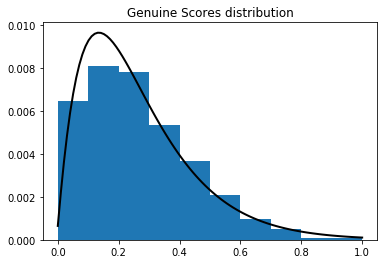

In [8]:
genuine_dict={}
genuine_dict["dist"],genuine_dict["points"]=plot_dist(genuine_scores,scaler,gamma,"Genuine Scores distribution")

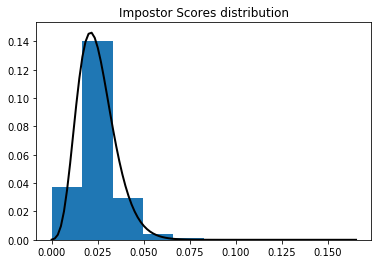

In [86]:
impostor_dict={}
impostor_dict["dist"],impostor_dict["points"]=plot_dist(impostor_scores,scaler,gamma,"Impostor Scores distribution")

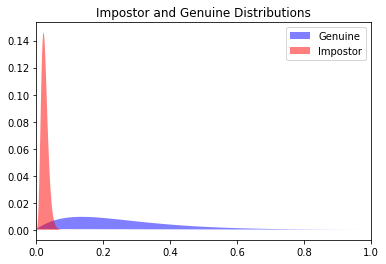

In [88]:
plot_joint_dist(genuine_dict,impostor_dict,x_lim=(0,1))

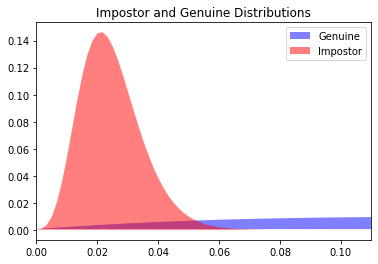

In [89]:
plot_joint_dist(genuine_dict,impostor_dict)

#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

False Match/Acceptance Rates (FMR/FAR), False Non-Match/Rejections Rates (FNMR/FRR) and Genuine Acceptance Rate (GAR)/True Match Rate (TMR) are calculated given the impostor $p(s | I)$ and genuine $p(s | G) $ probability distributions for every match score threshold value $\eta$. 

Given a set of match scores corresponding to the genuine class G and a set of match scores from the imposter class I this comes down to a counting problem, having $\mathcal{I}$ the indicator function (return 1 if x is true, else 0) we can compute
$$
FMR(\eta) = p(s \geq \eta | I) \approx \frac{1}{|I|} \sum_{s \in I} \mathcal{I}(s \geq \eta) 
$$
$$
FRR(\eta) = p(s < \eta | G) \approx \frac{1}{|G|} \sum_{s \in G} \mathcal{I}(s \geq \eta) 
$$
$$
GAR(\eta) = p(s \geq \eta | G) = 1 - FRR(\eta)
$$

<img src="img/FAR_FRR.png" width="300" height="auto" align="center"/>

To observe the impact of the threshold value, one often plots a ([Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve. Usually in these curves the GAR/TMR is plotted against the FMR for different decision threshold values $\eta$. For those familiar with binary classification systems outside of the biometrics literature; the GAR/TMR is often referred to as the True Positive Rate (TPR),  sensitivity or recall and FMR is also known as the False Positive Rate (FPR) or the False Accept Rate (FAR). 

<img src="img/ROC.png" width="400" height="auto" align="center"/>

#### <font color=blue> Task 1.2 Plot and discuss ROC curve 

* Calculate FPR, TPR from the matching scores.
* Plot FAR and FRR as a function of matching scores.
* Plot the ROC curve. Plot for linear and logarithmic scale if needed. What do you observe? 
* Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?

Use the [scikit-learn](https://scikit-learn.org/stable/index.html) package, which contains standard and advanced routines for machine learning, including classificaton and validation algorithms.
</font>

In [7]:
#Data loading
scores=np.concatenate([genuine_scores,impostor_scores])
#Get Scaler of total scores to transform range
scaler=MinMaxScaler().fit(scores.reshape(-1,1))

scores=scaler.transform(scores.reshape(-1,1)).flatten()
labels=np.concatenate([np.ones(len(genuine_scores)),np.zeros(len(impostor_scores))])


In [8]:
"""Calculate FPR, TPR from the matching scores."""
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(labels, scores)


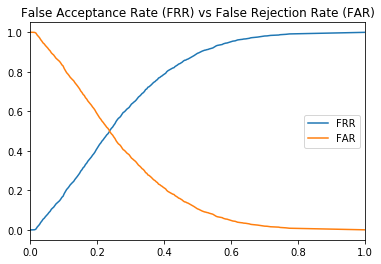

In [9]:
"""Plot FAR and FRR as a function of matching scores."""
#FRR=1-TPR ; FAR== FMR
frr=1-tpr

plt.plot(thresholds,frr,label="FRR")
plt.plot(thresholds,tpr,label="FAR")
plt.legend()
plt.xlim(0,1)
plt.title("False Acceptance Rate (FRR) vs False Rejection Rate (FAR)")
plt.show()

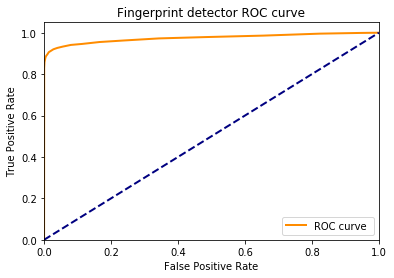

In [10]:
"""plot the ROC curve (TPR against the FPR for different threshold values)"""
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve ')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fingerprint detector ROC curve')
plt.legend(loc="lower right")
plt.show()

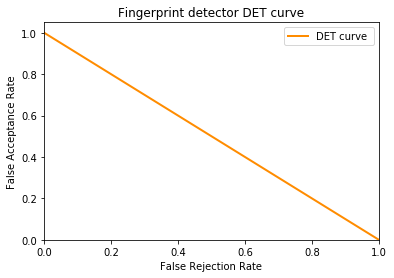

In [11]:
"""plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""

plt.plot(frr, tpr, color='darkorange',
         lw=2, label='DET curve ')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Rejection Rate')
plt.ylabel('False Acceptance Rate')
plt.title('Fingerprint detector DET curve')
plt.legend(loc="upper right")
plt.show()

#### 3. F1 and accuracy as metrics

While biometric systems are, traditionally, evaluated using FMR and FRR and ROC/DET curves, we can also have a look at traditional [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) such as classification accuracy (or error) and F1 measure. 

#### <font color=blue> Task 1.3 Calculate and discuss F1 and accuracy

* Plot F1 and accuracy as a function of the decision thresholds on the similarity score.
 * Interpret these two curves.
* Calculate the threshold for which F1 is maximal. 
 * Is it an interesting operating point?
 * What is the accuracy for this operating point? 
* Do the same for the classification error (or accuracy).
 * is there any difference between the two settings? Why(not)?
* Is accuracy a good performance measure for this case? Why(not)?

Use the scikit-learn [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) to assist.
</font>

In [12]:
def scores_to_preds(scores,threshold):
    y_pred=np.empty(len(scores))
    cond=(scores < threshold)
    y_pred[cond]=0
    y_pred[~cond]=1
    return y_pred

def init_metrics(metrics_dict):
    metrics={}
    for key in metrics_dict.keys():
        metrics[key]=[]
    return metrics

def log_metrics(scores,thresholds,metrics_dict):
    metrics=init_metrics(metrics_dict)
    for threshold in thresholds:
        #create y_pred
        y_preds=scores_to_preds(scores,threshold)
        #metrics
        for metric_name,metric in metrics_dict.items():
            metric_score=metric(labels,y_preds)
            metrics[metric_name].append(metric_score)
    return metrics

def plot_metric(scores,metrics,metric):
    plt.plot(thresholds,metrics[metric])
    plt.xlabel("score")
    plt.ylabel("{} ".format(metric))
    plt.title("{} as function of threshold".format(metric))
    plt.show()
    
def get_opt_threshold(tresholds,metrics,metric):
    return next(idx for idx in range(len(thresholds))
                      if metrics[metric][idx]==max(metrics[metric]))

In [13]:
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
from sklearn.metrics import accuracy_score,f1_score
thresholds=np.linspace(0,1,50)
metrics_dict={
    "f1":f1_score,
    "Accuracy":accuracy_score
}
#get f1 and accuracy as a funtion of thresholds
metrics=log_metrics(scores,
                    thresholds,
                    metrics_dict   
                )

# F1 

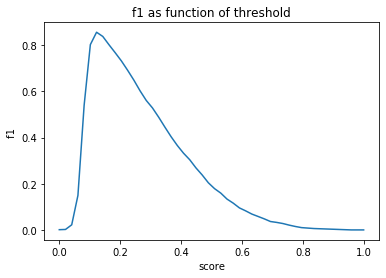

Optimal f1 value = 0.85546875 given at threshold 0.12244897959183673


In [14]:
plot_metric(thresholds,metrics,"f1")
"""Calculate the threshold for which F1 is maximal."""
opt_f1_id=get_opt_threshold(thresholds,metrics,"f1")

print("Optimal {} value = {} given at threshold {}".format("f1",
                                                           metrics["f1"][opt_f1_id],
                                                           thresholds[opt_f1_id]))

# Accuracy

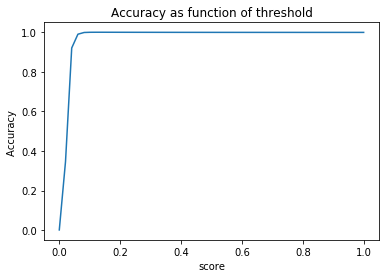

Optimal Accuracy value = 0.999741 given at threshold 0.12244897959183673


In [15]:
plot_metric(thresholds,metrics,"Accuracy")
"""Calculate the threshold for which Accuracy is maximal."""
opt_acc_id=get_opt_threshold(thresholds,metrics,"Accuracy")
print("Optimal {} value = {} given at threshold {}".format("Accuracy",
                                                           metrics["Accuracy"][opt_acc_id],
                                                           thresholds[opt_acc_id]))

#### 4. AUC and EER as summary measures

The overall performance (over all threshold settings) is typically expressed through:

* The Area Under the Curve (AUC) (with TPR((y-axis) vs FPR (x-axis))

<img src="img/AUC.png" width="250" height="auto"/>

The AUC can be used to compare different systems. The larger this number, the better.
However, since it is a summary measure, always inspect the full ROC curve to make decisions about performance given operating conditions (in wich FRR, FAR regime to work e.g.).

* The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance. 

<img src="img/EER.png" width="300" height="300"/>

#### <font color=blue> Task 1.4 Calculate and discuss AUC and EER and alternatives

* Calculate ROC AUC. 
 * Does it reveal anything about the performance of the system?
* Calculate (by approximation) the EER and plot it on the FAR-FRR curve.
 * Would you consider this a good operating point?
* Calculate the decision threshold for which the sum of FRR and FAR is minimal. 
 * Is it similar to the total classification error?
* Can you suggest other strategies that give you an "optimal" performance? Calculate and discuss their (de)merits.
        
</font>

In [108]:
"""Calculate the ROC AUC."""
from sklearn.metrics import auc
auc_roc=auc(fpr,tpr)

In [ ]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
# hints:
#  - you can use an interpolated or discrete approximation, both are fine
#  - avoid using a library for this assignment 
DON'T USE A LIBRARY

In [ ]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
# hint: same as above


#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


#### <font color=blue> Task 1.5 Experiment with Precision-Recall curves and related summary measures

* Calculate and plot the Precision-Recall curve for this system. 
 * What does it reveal about the performance of the system?
* Calculate the Area Under the PR-curve. 
 * Discuss.
* Calculate the average precision scores. 
 * discuss its value.
        
</font>

In [ ]:
"""Calculate and plot the Precision-Recall curve for this system"""


In [ ]:
"""Calculate the Area Under the PR-curve."""


In [ ]:
"""Calculate the average precision scores"""


## Validation of identification  

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 

<img src="img/CMC.jpg" width="500" height="auto"/>

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample). 



#### <font color=blue> Task 1.6 Experiment with CMC

* Calculate the Cumulative Matching Characteristic curve (implement this yourself)
* Compute the Rank-1 Recognition Rate.
        
</font>

In [ ]:
"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library


def CMC(similarity_matrix, n_ranks):
    
    # 1.1) compute the rank of the column elements (enrollees) for every row (user)
    # 1.2) calculate how frequent each rank occurs on the diagonal (diagonal contains the correct identifications)  
    # 1.3) compute the cumalulative frequency for each rank and normalise the result 
    # 1.4) return the CMC

    return None

# 1) compute the CMC for the first ±100 ranks
n_ranks = 100

# 2) plot the probability of recognition in function of the rank


In [ ]:
"""compute the Rank-1 Recognition Rate."""


#### <font color=blue> Task 1.7 Evaluate different biometric systems
    
With all above plots and metrics, you can start comparing different biometric systems (same biometric with different implementation, or different biometrics) in an authentication/verification and identification scenario. 
    
* Do this for comparing the left index from the right index finger.
* Do you see any differences in any of the curves or measures?
        
</font>